# ***Model Building***


# **Part 2: Building a sentiment classification engine.**


# Text Pre-processing and Model Building and Evaluation

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import FreqDist
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
%matplotlib inline

# model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve

# Mounting the drive

In [2]:
# importing drive to upload dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **## Importing and Pre-processing Data**

In [3]:
df_merged = pd.read_excel('/content/drive/My Drive/merged_excelfile.xlsx')

In [4]:
df_merged.head(10)

,overall,verified,reviewerID,asin,style,reviewerName,reviewText,summary,review_sentiment,Date&Time,...,also_buy,brand,feature,rank,details,price,category_new,new_rank,also_view_new,also_view_brand
0,5,1,A1LFAMJJM87RSG,B000W8RP3K,{'Color:': ' Silver'},Gayle Ledyard,This was a gift for my husband who does not wa...,Great phone,POSITIVE,2013-02-06,...,[],Motorola,['This product has been carefully audited and ...,"['>#544,961 in Cell Phones & Accessories (See ...",{},69.264778,Cell Phones,544961,"['B0009FCAJA', 'B005LRBF88', 'B002UHS0UI', 'B0...","['Motorola', 'GreatCall', 'BlackBerry']"
1,4,1,AEYUHCDXPEGC2,B000W8RP3K,{'Color:': ' Silver'},mark4348,works great,Four Stars,POSITIVE,2015-08-08,...,[],Motorola,['This product has been carefully audited and ...,"['>#544,961 in Cell Phones & Accessories (See ...",{},69.264778,Cell Phones,544961,"['B0009FCAJA', 'B005LRBF88', 'B002UHS0UI', 'B0...","['Motorola', 'GreatCall', 'BlackBerry']"
2,1,1,A14AQLOUQ6JUDZ,B000W8RP3K,{'Color:': ' Silver'},noemi,Not the original one. Very bad product. To fra...,Very bad product. To fragile,NEGATIVE,2015-01-28,...,[],Motorola,['This product has been carefully audited and ...,"['>#544,961 in Cell Phones & Accessories (See ...",{},69.264778,Cell Phones,544961,"['B0009FCAJA', 'B005LRBF88', 'B002UHS0UI', 'B0...","['Motorola', 'GreatCall', 'BlackBerry']"
3,5,1,A3FPRXIFC0JGPU,B000W8RP3K,{'Color:': ' Silver'},DAVALDAS,Just what I wanted,Five Stars,NEGATIVE,2014-12-07,...,[],Motorola,['This product has been carefully audited and ...,"['>#544,961 in Cell Phones & Accessories (See ...",{},69.264778,Cell Phones,544961,"['B0009FCAJA', 'B005LRBF88', 'B002UHS0UI', 'B0...","['Motorola', 'GreatCall', 'BlackBerry']"
4,5,1,A1IZUYUKA5FO39,B000W8RP3K,{'Color:': ' Silver'},Billy E. Maddox,An excellent phone but not a smart phone. I o...,An excellent phone but not a smart phone,POSITIVE,2014-09-26,...,[],Motorola,['This product has been carefully audited and ...,"['>#544,961 in Cell Phones & Accessories (See ...",{},69.264778,Cell Phones,544961,"['B0009FCAJA', 'B005LRBF88', 'B002UHS0UI', 'B0...","['Motorola', 'GreatCall', 'BlackBerry']"
5,3,1,A1TDHAKEDTJL2J,B000W8RP3K,{'Color:': ' Silver'},Hazwaste,I didn't expect perfection with this used phon...,"Phone Works OK, But Battery Only Lasts 2 hours...",POSITIVE,2014-02-12,...,[],Motorola,['This product has been carefully audited and ...,"['>#544,961 in Cell Phones & Accessories (See ...",{},69.264778,Cell Phones,544961,"['B0009FCAJA', 'B005LRBF88', 'B002UHS0UI', 'B0...","['Motorola', 'GreatCall', 'BlackBerry']"
6,5,1,A1LFAMJJM87RSG,B000W8RP3K,{'Color:': ' Silver'},Gayle Ledyard,This was a gift for my husband who does not wa...,Great phone,POSITIVE,2013-02-06,...,[],Motorola,['This product has been carefully audited and ...,"['>#544,961 in Cell Phones & Accessories (See ...",{},69.264778,Cell Phones,544961,"['B0009FCAJA', 'B005LRBF88', 'B002UHS0UI', 'B0...","['Motorola', 'GreatCall', 'BlackBerry']"
7,4,1,AEYUHCDXPEGC2,B000W8RP3K,{'Color:': ' Silver'},mark4348,works great,Four Stars,POSITIVE,2015-08-08,...,[],Motorola,['This product has been carefully audited and ...,"['>#544,961 in Cell Phones & Accessories (See ...",{},69.264778,Cell Phones,544961,"['B0009FCAJA', 'B005LRBF88', 'B002UHS0UI', 'B0...","['Motorola', 'GreatCall', 'BlackBerry']"
8,1,1,A14AQLOUQ6JUDZ,B000W8RP3K,{'Color:': ' Silver'},noemi,Not the original one. Very bad product. To fra...,Very bad product. To fragile,NEGATIVE,2015-01-28,...,[],Motorola,['This product has been carefully audited and ...,"['>#544,961 in Cell Phones & Accessories (See ...",{},69.264778,Cell Phones,544961,"['B0009FCAJA', 'B005LRBF88', 'B002UHS0UI', 'B0...","['Motorola', 'GreatCall', 'BlackBerry']"
9,5,1,A3FPRXIFC0JGPU,B000W8RP3K,{'Color:': ' Silver'},DAVALDAS,Just what I wanted,Five Stars,NEGATIVE,2014-12-07,...,[],Motorola,['This product has been carefully audited and ...,"['>#544,961 in Cell Phones & Accessories (See ...",{},69.264778,Cell Phones,544961,"['B0009FCAJA', 'B005LRBF88', 'B002UHS

In [5]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753 entries, 0 to 27752
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   overall           27753 non-null  int64  
 1   verified          27753 non-null  int64  
 2   reviewerID        27753 non-null  object 
 3   asin              27753 non-null  object 
 4   style             27753 non-null  object 
 5   reviewerName      27751 non-null  object 
 6   reviewText        27753 non-null  object 
 7   summary           27743 non-null  object 
 8   review_sentiment  27753 non-null  object 
 9   Date&Time         27753 non-null  object 
 10  description       27753 non-null  object 
 11  title             27753 non-null  object 
 12  also_buy          27753 non-null  object 
 13  brand             27753 non-null  object 
 14  feature           27753 non-null  object 
 15  rank              27753 non-null  object 
 16  details           27753 non-null  object

In [6]:
# mapping labels to 0 and 1
df_merged['review_sentiment'] = df_merged.review_sentiment.map({'POSITIVE':1, 'NEGATIVE':0})


In [7]:
df_reviews = df_merged[["reviewText","review_sentiment"]]

# **Pre-processing the text**

In [8]:
# Reading stop words from a text file in to a list
stop_words = [line.rstrip('\n') for line in open('/content/drive/MyDrive/sentiment_analysis/stop_words_long.txt')]

In [9]:
# remove contraction and make it as normal string
contractionsMain = {"ain't": "is not", "aren't": "are not","can't": "can not", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def getcontractions(contractionsMain):
    contraction_key = re.compile('(%s)' % '|'.join(contractionsMain.keys()))
    return contractionsMain, contraction_key

contractions, contraction_key = getcontractions(contractionsMain)
def replacecontractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contraction_key.sub(replace, text)


In [10]:
def remove_punctuations(text):
    text = re.sub('[^A-Za-z]+', ' ', text)

    return text

In [11]:
#function to remove numbers and punctuation marks
puncts_list=['!','@','#','$','%','^','&','*','(',')','-','_','+','=','{','}','[',']',':',';','?','/','\\','|','.','<','>']
def removepuctuationmarks(x):
    x = str(x)
    for punct in puncts_list:
        if punct in x:
            x = x.replace(punct, '')
    return x

In [12]:
# replace charachter appearing for more than twice in any word to single character
def replace_multiple_characters(text):
        #repeat_pattern = re.compile(r'(\w)\1*')
        repeat_pattern = re.compile(r'(\w)\1{2,}')
        match_substitution = r'\1\1'
        new_word = repeat_pattern.sub(match_substitution,text)
        repeat_pattern1 = re.compile(r'(\w)\1{1,}$')
        match_substitution1 = r'\1'
        new_word = repeat_pattern1.sub(match_substitution1,new_word)
        return new_word

In [13]:
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
def preprocessText(document):
     # tokenize into words
         # change sentence to lower case
    document = document.lower()
    words = word_tokenize(document)
    # remove contractions
    words = [ replacecontractions(word) for word in words ]

    # remove stop words
    words = [word for word in words if word not in stop_words]

    # remove punctuation marks

    words=[remove_punctuations(word) for word in words]

    words=[replace_multiple_characters(word) for word in words]

    # remove stop words
    words = [word for word in words if word not in stop_words]

    #apply lemmatization
    words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]

    words=[word for word in words if len(word)>2]
    # join words to make sentence
    document = " ".join(words)

    return document

In [14]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
df_reviews["reviewText"]=[preprocessText(str(x)) for x in df_reviews["reviewText"]]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-14-d7aca8dc2815>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews["reviewText"]=[preprocessText(str(x)) for x in df_reviews["reviewText"]]


In [15]:
# convert to X and y
X = df_reviews.reviewText
y = df_reviews.review_sentiment
print(X.shape)
print(y.shape)

(27753,)
(27753,)


In [16]:
# splitting into test and train
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [17]:
# vectorizing the sentences
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [18]:
vect.fit(X_train)

CountVectorizer()

In [19]:
# printing the vocabulary
vect.vocabulary_


{'good': 6280,
 'feature': 5395,
 'nice': 10472,
 'excellen': 5014,
 'phone': 12485,
 'stop': 15771,
 'month': 9426,
 'great': 6416,
 'advertise': 277,
 'version': 17767,
 'support': 16057,
 'gsm': 6485,
 'band': 1195,
 'work': 18368,
 'internationally': 7679,
 'depend': 3763,
 'cellular': 2258,
 'service': 14765,
 'provider': 13213,
 'check': 2362,
 'countries': 3190,
 'nhttp': 10463,
 'ww': 18467,
 'worldtimezone': 18393,
 'com': 2685,
 'html': 7047,
 'nas': 9770,
 'warn': 18000,
 'not': 10890,
 'cdma': 2238,
 'network': 10212,
 'verizon': 17756,
 'nthis': 11382,
 'budget': 1894,
 'usually': 17635,
 'find': 5492,
 'higher': 6851,
 'definitely': 3683,
 'cheaper': 2349,
 'available': 1056,
 'market': 8896,
 'filter': 5480,
 'dual': 4388,
 'sim': 14993,
 'quad': 13365,
 'cameras': 2079,
 'ips': 7778,
 'display': 4102,
 'better': 1440,
 'price': 13021,
 'range': 13484,
 'nwhat': 11561,
 'lack': 8191,
 'screen': 14585,
 'resolution': 14041,
 'like': 8447,
 'high': 6849,
 'honest': 6948,
 

In [20]:
# transforming the train and test datasets
X_train_transformed = vect.transform(X_train)
X_test_transformed = vect.transform(X_test)


In [21]:
# note that the type is transformed (sparse) matrix
print(type(X_train_transformed))
print(X_train_transformed)

<class 'scipy.sparse._csr.csr_matrix'>
  (0, 5395)	1
  (0, 6280)	1
  (1, 10472)	1
  (2, 6280)	1
  (3, 5014)	1
  (4, 9426)	1
  (4, 12485)	1
  (4, 15771)	1
  (5, 76)	1
  (5, 277)	1
  (5, 450)	1
  (5, 602)	6
  (5, 633)	1
  (5, 722)	1
  (5, 747)	2
  (5, 775)	1
  (5, 1056)	1
  (5, 1195)	4
  (5, 1440)	1
  (5, 1602)	1
  (5, 1894)	2
  (5, 2079)	1
  (5, 2140)	2
  (5, 2238)	1
  (5, 2258)	1
  :	:
  (20810, 14189)	1
  (20810, 15213)	1
  (20810, 15666)	1
  (20810, 16641)	1
  (20810, 17712)	1
  (20810, 18150)	1
  (20811, 6416)	1
  (20811, 13105)	1
  (20812, 10472)	1
  (20812, 16477)	1
  (20813, 1195)	1
  (20813, 1508)	1
  (20813, 1994)	1
  (20813, 2140)	1
  (20813, 2770)	1
  (20813, 3410)	1
  (20813, 6151)	1
  (20813, 6760)	1
  (20813, 7556)	1
  (20813, 9140)	1
  (20813, 9365)	1
  (20813, 9465)	1
  (20813, 11844)	1
  (20813, 14993)	1
  (20813, 17397)	1


# **Building and Evaluating Model**

Model 1

In [22]:
# function to plot confusion matrix
def plot_confusion_matrix(confusion_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix.flatten()]

    labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')
    plt.title("Confusion matrix")
    plt.show()

In [23]:
# training the NB model and making predictions
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

# fit
mnb.fit(X_train_transformed,y_train)

#Applying the model on train set too
y_pred_train = mnb.predict(X_train_transformed) # returns classes 0 and 1

y_pred_proba_tr = mnb.predict_proba(X_train_transformed) # returns the probability of a review being positive

# predict class
y_pred_class = mnb.predict(X_test_transformed)

# predict probabilities
y_pred_proba = mnb.predict_proba(X_test_transformed)


In [24]:
# printing  accuracy on train dataset
from sklearn import metrics
y_pred_train = mnb.predict(X_train_transformed)

print ("Accuracy on train dataset :")
metrics.accuracy_score( y_train, y_pred_train)

Accuracy on train dataset :


0.8821466320745652

In [25]:
# printing the  accuracy on test dataset
from sklearn import metrics
print ("Accuracy on test dataset :")
metrics.accuracy_score(y_test, y_pred_class)

Accuracy on test dataset :


0.8630926646490849

Confusion Matrix for Train Dataset

In [26]:
# confusion matrix
confusion_train =metrics.confusion_matrix(y_train, y_pred_train)
print(confusion_train)

[[ 3228  1892]
 [  561 15133]]


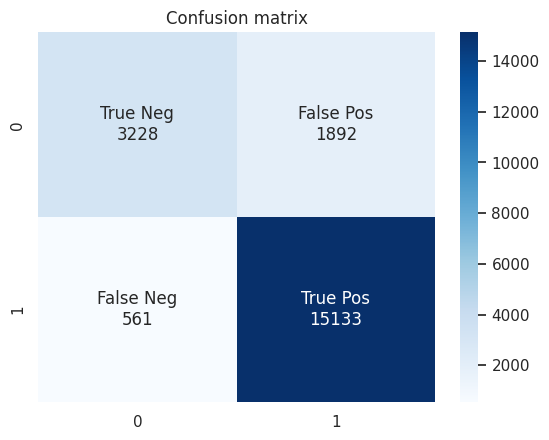

In [27]:
# ploting confusion matrix
plot_confusion_matrix(confusion_train)

Confusion Matrix for Test Dataset

In [28]:
# confusion matrix
confusion_test =metrics.confusion_matrix(y_test, y_pred_class)
print(confusion_test)

[[ 932  763]
 [ 187 5057]]


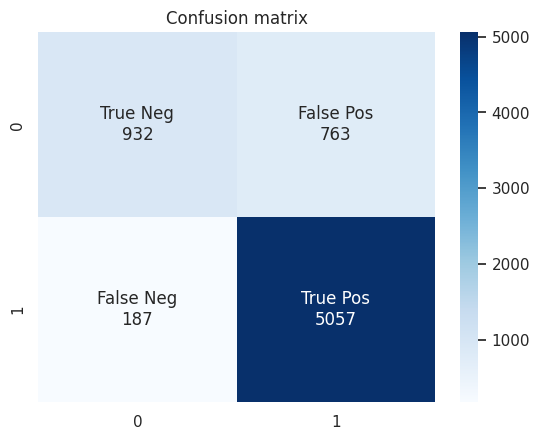

In [29]:
# ploting confusion matrix
plot_confusion_matrix(confusion_test)

Let's calculate other Matrics - Sensitivity, Specificity, Precision,Recall and F1 score for train and test dataset

In [30]:
# for train dataset
TN_train = confusion_train[0, 0]
FP_train = confusion_train[0, 1]
FN_train = confusion_train[1, 0]
TP_train = confusion_train[1, 1]


In [31]:
# for test datset
TN_test = confusion_test[0, 0]
FP_test = confusion_test[0, 1]
FN_test = confusion_test[1, 0]
TP_test = confusion_test[1, 1]



Sensitivity Metrics

In [32]:
sensitivity_train = TP_train / float(FN_train + TP_train)
sensitivity_test = TP_test / float(FN_test + TP_test)
print("sensitivity on train dataset",sensitivity_train)
print("sensitivity on test dataset",sensitivity_test)

sensitivity on train dataset 0.9642538549764241
sensitivity on test dataset 0.9643401983218917


Specificity Metrics

In [33]:
specificity_train = TN_train / float(TN_train + FP_train)
specificity_test = TN_test / float(TN_test + FP_test)
print("specificity on train dataset",specificity_train)
print("specificity on train dataset",specificity_test)

specificity on train dataset 0.63046875
specificity on train dataset 0.5498525073746313


Precision Metrics

In [34]:
precision_train = TP_train / float(TP_train + FP_train)
precision_test = TP_test / float(TP_test + FP_test)
print("precision on train dataset",precision_train)
print("precision on test dataset",precision_test)

precision on train dataset 0.8888693098384728
precision on test dataset 0.8689003436426117


In [35]:
print("F1 SCORE for train dataset :",metrics.f1_score(y_train, y_pred_train))
print("F1 SCORE for test dataset :",metrics.f1_score(y_test, y_pred_class))

F1 SCORE for train dataset : 0.9250282710351783
F1 SCORE for test dataset : 0.9141359363702096


Recall Metrics

In [36]:
print("RECALL SCORE on train dataset :", metrics.recall_score(y_train, y_pred_train))
print("RECALL SCORE on test dataset :", metrics.recall_score(y_test, y_pred_class))

RECALL SCORE on train dataset : 0.9642538549764241
RECALL SCORE on test dataset : 0.9643401983218917


In [37]:
y_pred_class

array([1, 1, 1, ..., 0, 1, 1])

In [38]:
y_pred_proba

array([[2.45988277e-01, 7.54011723e-01],
       [1.55184744e-01, 8.44815256e-01],
       [1.88862768e-10, 1.00000000e+00],
       ...,
       [9.59767679e-01, 4.02323206e-02],
       [1.97432642e-18, 1.00000000e+00],
       [3.08590790e-02, 9.69140921e-01]])

ROC Curve



In [39]:
# creating an ROC curve
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt

In [40]:
# for train dataset
false_positive_rate_tr, true_positive_rate_tr, thresholds_tr = roc_curve(y_train, y_pred_proba_tr[:,1])
roc_auc_tr = auc(false_positive_rate_tr, true_positive_rate_tr)

In [41]:
# for test dataset
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

In [42]:
# area under the curve
print (roc_auc)

0.8957693467347989


In [43]:
# matrix of thresholds, tpr, fpr
pd.DataFrame({'Threshold': thresholds,
              'TPR': true_positive_rate,
              'FPR':false_positive_rate
             })

,Threshold,TPR,FPR
0,2.000000e+00,0.000000,0.00000
1,1.000000e+00,0.102212,0.00826
2,1.000000e+00,0.103547,0.00826
3,1.000000e+00,0.105263,0.00885
4,1.000000e+00,0.105454,0.00885
...,...,...,...
1351,3.108398e-22,0.999809,0.99351
1352,1.561440e-25,0.999809,0.99587
1353,1.590790e-27,0.999809,0.99823
1354,6.136119e-31,1.000000,0.99823


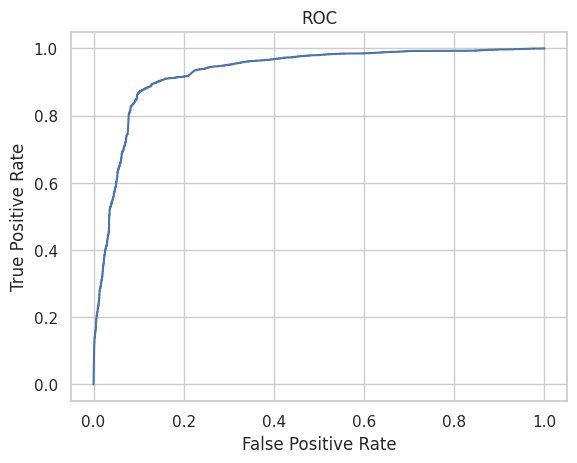

In [44]:
# plotting the ROC curve for train set
%matplotlib inline
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate_tr, true_positive_rate_tr)

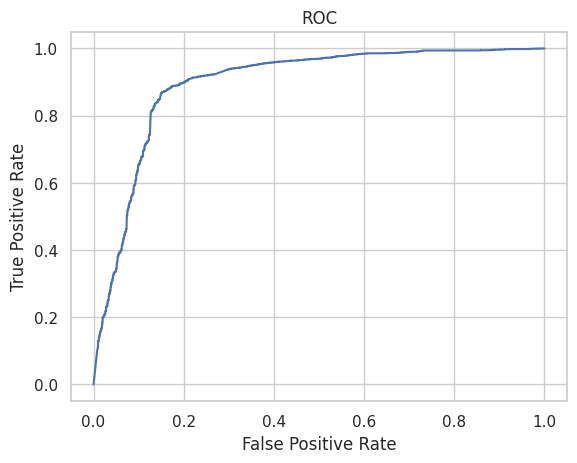

In [45]:
# plotting the ROC curve for test set
%matplotlib inline
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate)

We have checked sensitivity- specificity and precision-recall matrix for the model.

Models accuracy,sensitivity,specificity on train and test dataset are :
*   Train dataset :accuracy(87%),sensitivity (95%),specificity(64%)
*   Test Dataset : accuracy(86%),sensitivity (95%),specificity(59%)



  


Models precision,recall,F1 score on train and test dataset are :


*  Train dataset :precision(88%),recall (95%),F1 score(92%)
*  Test Dataset : precision(87%),recall (95%),F1 score(91%)


*   List ite





Area under curve : 90%

Since the distribution of the dataset is imbalanced with more positives, many reviews which were negative were incorrectly classified as positives by the NB model and hence the low specificity. From a business point of view, this is not a very good model as you will miss out on the negatives of your competitors. Knowing the weaknesses of your competitors help you design better features for the product and devise your marketing strategies accordingly.

In [46]:
# Printing the classification report
print("report for train set")
print(classification_report(y_train, y_pred_train))
print("report for test set")
print(classification_report(y_test, y_pred_class))

report for train set
              precision    recall  f1-score   support

           0       0.85      0.63      0.72      5120
           1       0.89      0.96      0.93     15694

    accuracy                           0.88     20814
   macro avg       0.87      0.80      0.82     20814
weighted avg       0.88      0.88      0.88     20814

report for test set
              precision    recall  f1-score   support

           0       0.83      0.55      0.66      1695
           1       0.87      0.96      0.91      5244

    accuracy                           0.86      6939
   macro avg       0.85      0.76      0.79      6939
weighted avg       0.86      0.86      0.85      6939



Macro average is just the average of performance metrics of both the classes where as the weighted average assigns weights to the metrics of the classes according to their distribution in the original dataset. Macro and weighted averages are more useful in a multi-class calssification problems because in case of a binary classification, we already know what our positive and negative classes are to evaluate the model performance.

# **Model 2:**

With Oversampling

A skewed data is the one where there are more training examples for one class than another. This was evident from the specificity which was calculated in the model above. This can cause the decision boundary weights to be biased. This causes the classifier to unwittingly prefer one class over the other.

We have shown the reason for the bias in the previous model and propose to alleviate the problem by using a method called Random oversampling. Random oversampling involves randomly selecting samples from the minority class (in our case 0s), with replacement, and adding them to the training dataset such that there is an equal distribution of the classes.

In [47]:
# splitting the data into test and train
from sklearn.model_selection  import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [48]:
pd.Series(y_train).value_counts()

1    15694
0     5120
Name: review_sentiment, dtype: int64

Why oversampling is done only on training set?
If both the train and test data are oversampled, we may end up having same points in both the sets. Hence the model performance obtained cannot be reliable as the test set is not independent of the train set.

In [49]:
#from imblearn import over_sampling
from imblearn import over_sampling
ros = over_sampling.RandomOverSampler(random_state=0)

In [50]:
X_train, y_train = ros.fit_resample(pd.DataFrame(X_train), pd.Series(y_train))

In [51]:
pd.Series(y_train).value_counts()

1    15694
0    15694
Name: review_sentiment, dtype: int64

In [52]:
#Distribution of the data in terms of proportions can now be seen as 50 -50
print("Percent of 1s: ", 100*pd.Series(y_train).value_counts()[1]/pd.Series(y_train).value_counts().sum(), "%")
print("Percent of 0s: ", 100*pd.Series(y_train).value_counts()[0]/pd.Series(y_train).value_counts().sum(), "%")

Percent of 1s:  50.0 %
Percent of 0s:  50.0 %


In [53]:
# vectorizing the sentences
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [54]:
# The CountVectorizer object, vect takes in a list of string as an argument. to get a list of string from a 2D array,
# we convert the 2D array to a dataframe and then convert it to a list.

X_train = pd.DataFrame(X_train).iloc[:,0].tolist()

#Printing a few samples from the list
X_train[:6]

['good feature',
 'nice',
 'good',
 'excellen',
 'phone stop month',
 'great phone advertise version support gsm band work internationally depend band cellular service provider check countries support band  nhttp  ww worldtimezone com gsm html n nas warn phone not work cdma network verizon  n nthis great budget phone feature usually find higher phone definitely cheaper phone available market filter dual sim quad band dual cameras ips display not better phone price range n nwhat lack phone  n  screen resolution not like high phone honest not notice difference screen size not high end phone comparison premium phone uhd display not apples apples phone lacks n n  internal storage issue note expand  gb microsd card change introduce android lollipop not allow apps acces microsd card app related data storage use lot internal storage limit mind n noveral great budget phone write review sept google days announce version android market android phone hold release android phone natively preloaded 

In [55]:
#Fitting X_train into a vectorizer
vect.fit(X_train)

CountVectorizer()

In [56]:
# Transforming the train and test datasets
X_train_transformed = vect.transform(X_train)
X_test_transformed = vect.transform(X_test)

## **Naive Bayes model with random oversampling**

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [58]:
# training the NB model and making predictions
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

# fit
mnb.fit(X_train_transformed,y_train)

# Training dataset
y_pred_train = mnb.predict(X_train_transformed)
y_pred_proba_tr = mnb.predict_proba(X_train_transformed)

# Testing dataset
y_pred = mnb.predict(X_test_transformed)
y_pred_proba = mnb.predict_proba(X_test_transformed)

In [59]:
# note that alpha=1 is used by default for smoothing
mnb


MultinomialNB()

## **Model evauation on Test dataset**

In [60]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [61]:
# printing the overall accuracy
from sklearn import metrics
print("Accuracy for test set is: ", metrics.accuracy_score(y_test, y_pred))
print("Accuracy for train set is: ", metrics.accuracy_score(y_train, y_pred_train))

Accuracy for test set is:  0.8636691165874045
Accuracy for train set is:  0.8853702051739518


Confusion matrix for train and test set


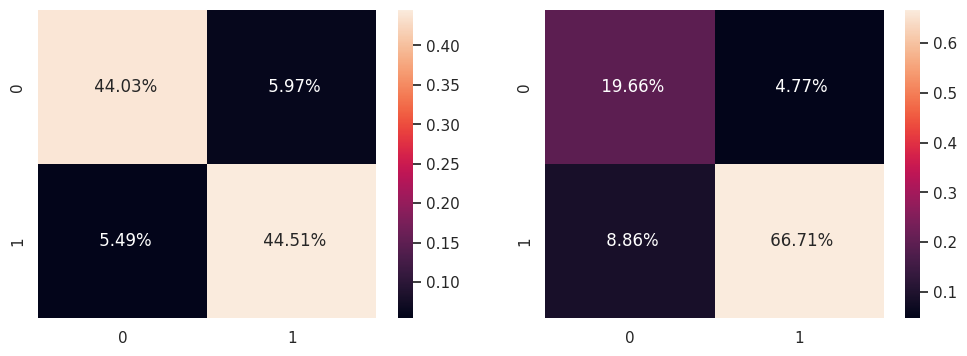

In [62]:
#Confusion matrix for the train data
import seaborn as sns
import matplotlib.pyplot as plt

print("Confusion matrix for train and test set")

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
# confusion matrix for train set
cm_train = metrics.confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train/np.sum(cm_train), annot=True , fmt = ' .2%')
# help(metrics.confusion_matrix)

plt.subplot(1,2,2)
# confusion matrix for the test data
cm_test = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(cm_test/np.sum(cm_test), annot=True , fmt = ' .2%')

plt.show()

In [63]:
# creating an ROC curve
# from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#for test set
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
#for train set
false_positive_rate_tr, true_positive_rate_tr, thresholds_tr = roc_curve(y_train, y_pred_proba_tr[:,1])
roc_auc_tr = auc(false_positive_rate, true_positive_rate)


In [64]:
# area under the curve
print ("for train set: ",roc_auc_tr)
print ("for test set: ",roc_auc)

for train set:  0.8959461466285953
for test set:  0.8959461466285953


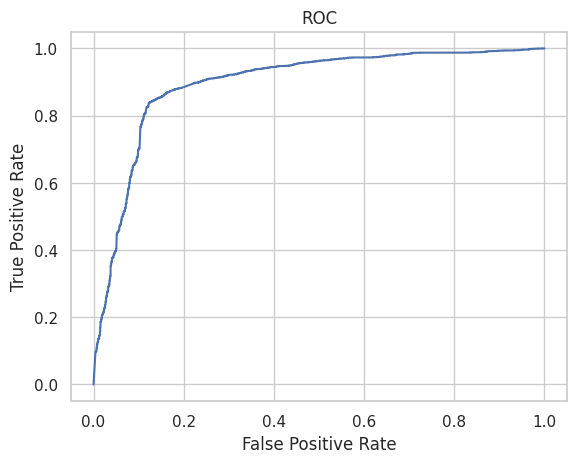

In [65]:
# plotting the ROC curve for test set
%matplotlib inline
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate)

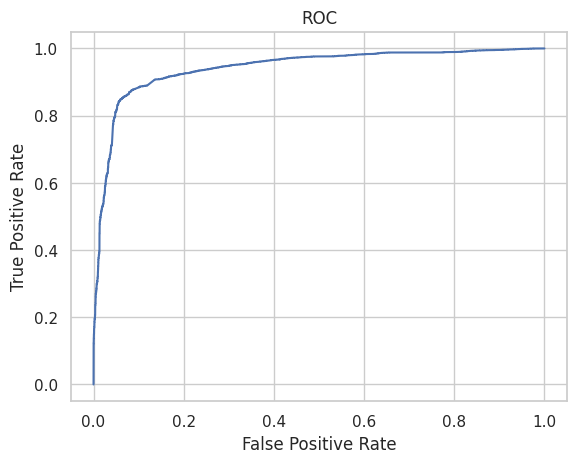

In [66]:
# plotting the ROC curve for train set
%matplotlib inline
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate_tr, true_positive_rate_tr)


In [67]:
# storing the values in variables
#for test set
TN = cm_test[0, 0]
FP = cm_test[0, 1]
FN = cm_test[1, 0]
TP = cm_test[1, 1]
#For train set
TN_tr = cm_train[0, 0]
FP_tr = cm_train[0, 1]
FN_tr = cm_train[1, 0]
TP_tr = cm_train[1, 1]

In [68]:
#specificity for test and train set.
specificity_tr = TN_tr / float(TN_tr + FP_tr)
print("specificity for train set: ",specificity_tr)
specificity = TN / float(TN + FP)
print("specificity for test set: ",specificity)

specificity for train set:  0.8805913087804257
specificity for test set:  0.8047197640117995


In [69]:
#Calculating the Sensitivity for train and test set
sensitivity_tr = TP_tr / float(FN_tr + TP_tr)
print("sensitivity for train set: ",sensitivity_tr)
sensitivity = TP / float(FN + TP)
print("sensitivity for test set: ",sensitivity)

sensitivity for train set:  0.8901491015674781
sensitivity for test set:  0.8827231121281465


Precision

We have checked sensitivity- specificity and precision-recall matrix for the model.


Models accuracy,sensitivity,specificity on train and test dataset are :
Train dataset :accuracy(88%),sensitivity (88%),specificity(87%)
Test Dataset : accuracy(89%),sensitivity (87%),specificity(82%)

Area under curve : 90% for both train and test dataset.


The test sensitivity and specificity of the model without oversampling were 0.95 and 0.59 respectively. The application of oversampling model has resulted in an equal distribution of the binary labels. This has resulted in a jump in specificity by 0.23 with a slight decrease in the sensitivity by 0.08. From a business point of view, we can say that this is a better model as compared to the one that was built without oversampling.

In [70]:
# Printing the classification report
print("report for train set")
print(classification_report(y_train, y_pred_train))
print("report for test set")
print(classification_report(y_test, y_pred))

report for train set
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     15694
           1       0.88      0.89      0.89     15694

    accuracy                           0.89     31388
   macro avg       0.89      0.89      0.89     31388
weighted avg       0.89      0.89      0.89     31388

report for test set
              precision    recall  f1-score   support

           0       0.69      0.80      0.74      1695
           1       0.93      0.88      0.91      5244

    accuracy                           0.86      6939
   macro avg       0.81      0.84      0.82      6939
weighted avg       0.87      0.86      0.87      6939

